# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [25]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [28]:
cars = pd.read_csv('data/vehicles.csv')
cars.head()
cars.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


Using a dataset of 426K used-car listings that includes attributes such as region, year of manufacture, manufacturer, model, vehicle condition, engine cylinder count, fuel type, body size, and U.S. state, formulate a machine learning regression task to predict the numeric target variable "price". 

The analysis will involve exploring the dataset, cleaning it for NULL values, appropriate encoding of categorical values (e.g. region, state, manufacturer), and the development of predictive models (e.g. scaled ridge model, GridSearch CV) to quantify how each feature influences market value.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [20]:
#explore general features of each column and #null values 
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Based on the above information, of the 426880 entries:

1. Only 4 of the 18 features have non-NULL values. The remaining 14 - the year, manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, VIN, drive, size, type, paint_color - all have NULL values. Of these, 6 features - condition, cylinders, VIN, drive, size, and paint_color - have significant % of NULL rows. In particular, less than 30% of the rows have a "size" feature filled. 

In [19]:
#explore numerical columns 
cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


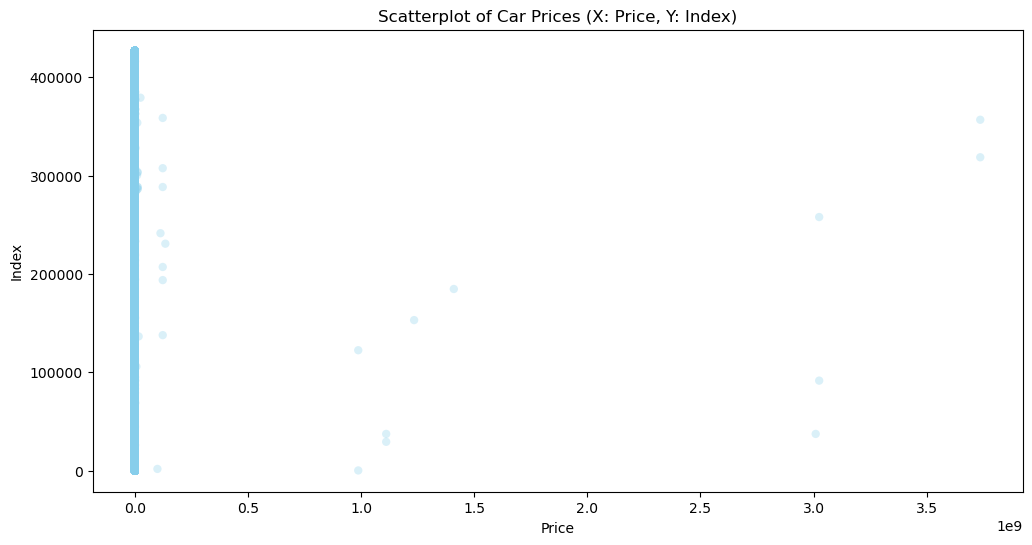

In [33]:
# Scatterplot of price vs index using matplotlib (axes inverted)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(cars['price'], cars.index, alpha=0.3, color='skyblue', edgecolors='none')
plt.title('Scatterplot of Car Prices (X: Price, Y: Index)')
plt.xlabel('Price')
plt.ylabel('Index')
plt.show()

In [27]:
# Count the number of rows where price is 0
zero_price_count = (cars['price'] == 0).sum()
print('Number of rows with price = 0:', zero_price_count)

Number of rows with price = 0: 32895


2. the mean price is about 75K, but with a significant standard deviation of 12M, and about 8% of the values being 0, max value being 3.7B. From the histogram / scatter plot, there is clearly significant skew in the data, with most cars being less than 100M in price, but a few going into the billions. 


In [14]:
# Count unique values for selected columns
print('Unique manufacturers:', cars['manufacturer'].nunique())
print('Unique models:', cars['model'].nunique())
print('Unique regions:', cars['region'].nunique())
print('Unique states:', cars['state'].nunique())
print('Unique fuel:', cars['fuel'].nunique())
print('Unique title statuses:', cars['title_status'].nunique())
print('Unique transmission rates:', cars['transmission'].nunique())

Unique manufacturers: 42
Unique models: 29649
Unique regions: 404
Unique states: 51
Unique fuel: 5
Unique title statuses: 6
Unique regions: 404
Unique states: 51
Unique fuel: 5
Unique title statuses: 6
Unique transmission rates: 3
Unique transmission rates: 3



3. In terms of categorical data and its unique values, it appears fuel, title status, transmission are good categorical features to look into, with very few categories amongst them (3 - 6). The models feature on the otherhand seems to have a vast number of possibilities and may not be useful to model. 



In [18]:
#explore unique values in fuel, title statuses, and transmission types columns 
print('Fuel types:', cars['fuel'].unique())
print('Title Statuses:', cars['title_status'].unique())
print('Transmission types:', cars['transmission'].unique())


Fuel types: [nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
Title Statuses: [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
Transmission types: [nan 'other' 'automatic' 'manual']


In [34]:
# Extract a few random rows to compare ID and VIN columns
sample = cars[['id', 'VIN']].sample(5, random_state=42)
print(sample)
print('Are ID and VIN identical for these rows?')
print((sample['id'] == sample['VIN']).values)

                id                VIN
100905  7315883828  1FTFX1EG9HKD14814
143835  7314599643                NaN
20235   7308399808                NaN
300734  7312663807                NaN
316249  7315368523  1GNSKGKC7KR124145
Are ID and VIN identical for these rows?
[False False False False False]


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.